<a href="https://colab.research.google.com/github/bkricardo/attention_base_speech_to_text/blob/main/attention_code_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#connect google drive
from google.colab import drive
import json
drive.mount("/content/gdrive",force_remount=True)
# %cd ./gdrive/My Drive/11785-hw/hw4/data
%cd ./gdrive/My Drive/11785-hw/hw4/data

Mounted at /content/gdrive
/content/gdrive/My Drive/11785-hw/hw4/data


In [ ]:
!nvidia-smi

Tue May  4 01:02:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    44W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
'''
@Author: yuanpei-wang
@Last Edit: 2021/03/28
'''

import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
import torch.optim as optim
import torch.nn.utils as utils
from torch.autograd import Variable
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
from torch.utils import data

from tqdm.notebook import tqdm as tq
from torch.nn.utils.rnn import *

cuda = torch.cuda.is_available()
print(cuda, sys.version)
device = torch.device("cuda" if cuda else "cpu")
np.random.seed(11785)
torch.manual_seed(11785)

LETTER_LIST = ['<sos>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', \
         'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '-', "'", '.', '_', '+', ' ', '<eos>']

True 3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]


In [ ]:
!pip install python-levenshtein
import Levenshtein as lev

In [ ]:
import Levenshtein as lev

In [ ]:
def create_dictionaries(letter_list):
    '''
    Create dictionaries for letter2index and index2letter transformations
    '''
    letter2index = dict()
    index2letter = dict()
    for index, letter in enumerate(LETTER_LIST):
        letter2index[letter] = index
        index2letter[index] = letter

    return letter2index, index2letter


def transform_letter_to_index(raw_transcripts):
    '''
    Transforms text input to numerical input by converting each letter
    to its corresponding index from letter_list

    Args:
        raw_transcripts: Raw text transcripts with the shape of (N, )

    Return:
        transcripts: Converted index-format transcripts. This would be a list with a length of N
    '''
    index_list = []
    for sentence in raw_transcripts:
        letters = [letter2index['<sos>']]
        # print(sentence)
        for word in sentence:
            # print(word)
            new_word = word.decode('utf-8')

            for char in new_word:
                letters.append(letter2index[char])

            letters.append(letter2index[' '])
        letters.pop()
        letters.append(letter2index['<eos>'])
        index_list.append(letters)

    return index_list

# Create the letter2index and index2letter dictionary
letter2index, index2letter = create_dictionaries(LETTER_LIST)

In [ ]:
#load toy dataset
# %cd ./gdrive/My Drive/11785-hw/hw4/toy_data

# Load the training, validation and testing data
train_data = np.load('train.npy', allow_pickle=True, encoding='bytes')
valid_data = np.load('dev.npy', allow_pickle=True, encoding='bytes')
# test_data = np.load('test.npy', allow_pickle=True, encoding='bytes')

# Load the training, validation raw text transcripts
raw_train_transcript = np.load('train_transcripts.npy', allow_pickle=True,encoding='bytes')
raw_valid_transcript = np.load('dev_transcripts.npy', allow_pickle=True,encoding='bytes')

# TODO: Convert the raw text transcripts into indexes
train_transcript = transform_letter_to_index(raw_train_transcript)
valid_transcript = transform_letter_to_index(raw_valid_transcript)

In [ ]:
len(train_transcript)

28539

In [ ]:
class MyDataset(data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        # For testing set, return only x
        if self.Y == None:
            return torch.tensor(self.X[index].astype(np.float32))
        # For training and validation set, return x and y
        else:
            return torch.tensor(self.X[index].astype(np.float32)), torch.tensor(self.Y[index])

def collate_train_val(data):
    """
    Return:
        pad_x: the padded x (training/validation speech data)
        pad_y: the padded y (text labels - transcripts)
        x_len: the length of x
        y_len: the length of y
    """
    x = [output[0] for output in data]
    y = [output[1][1:] for output in data]    #need to ask TA!!!!!!
    # (inputs, targets) = zip(*batch)
    x_pad = pad_sequence(x, batch_first=True) # dim (B, T, C) since batch_first is true, (T, B, C) if false
    y_pad = pad_sequence(y, batch_first=True)  #can be a problem for, maybe need to pad with letter2index('eos')

    x_lens = torch.LongTensor([len(x) for x in x])
    y_lens = torch.LongTensor([len(y) for y in y])
    return x_pad, y_pad, x_lens, y_lens

def collate_test(data):
    """
    Return:
        pad_x: the padded x (testing speech data)
        x_len: the length of x
    """
    inputs = [x for x in batch]
    inputs_pad = pad_sequence(inputs, batch_first=True) # dim (B, T, C) since batch_first is true, (T, B, C) if false
    inputs_lens = torch.LongTensor([len(x) for x in batch])

    return inputs_pad,inputs_lens

In [ ]:
# Create datasets
train_dataset = MyDataset(train_data,train_transcript)
valid_dataset = MyDataset(valid_data,valid_transcript)
# test_dataset = MyDataset(test_data,Y= None)

# Create data loaders
train_loader = data.DataLoader(
            dataset = train_dataset,
            batch_size = 32,
            num_workers = 4,
            shuffle = True,
            collate_fn = collate_train_val,
            pin_memory = True)

valid_loader = data.DataLoader(
            dataset = valid_dataset,
            batch_size = 32,
            num_workers = 4,
            shuffle = True,
            collate_fn = collate_train_val,
            pin_memory = True)

In [ ]:
class pBLSTM(nn.Module):
    '''
    Pyramidal BiLSTM
    Read paper and understand the concepts and then write your implementation here.
    '''
    def __init__(self, input_dim, hidden_dim):
        super(pBLSTM, self).__init__()
        self.blstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=1, bidirectional=True, batch_first=True)

    def forward(self, x):

        x_padded, x_len = pad_packed_sequence(x, batch_first=True)  #(B,T ,hidden), unpack x

        x_len.to(device)

        # cut the x_padded if time length is odd
        x_padded = x_padded[:,:(x_padded.size(1) // 2) * 2, :]

        #concat 2 time step to 1 time step with 2 dimension concated, (B, T/2, hidden * 2)
        x_concat = x_padded.reshape(x_padded.size(0), x_padded.size(1) // 2, x_padded.size(2) * 2)
        x_len = x_len // 2

        x_packed = pack_padded_sequence(x_concat,lengths = x_len, enforce_sorted=False, batch_first=True)

        out = self.blstm(x_packed)[0]

        return out

In [ ]:
class Encoder(nn.Module):
    '''
    Encoder takes the utterances as inputs and returns the key, value and unpacked_x_len.
    Key and value are linear projections of the output from pBLSTM network for the laster.
    '''
    def __init__(self, input_dim, encoder_hidden_dim, key_value_size=128):
        super(Encoder, self).__init__()
        # The first LSTM at the very bottom
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=encoder_hidden_dim, bidirectional=True, batch_first=True)


        # TODO: Define the blocks of pBLSTMs
        # ...
        self.plstm = nn.Sequential(
            pBLSTM(encoder_hidden_dim*4, encoder_hidden_dim),
            pBLSTM(encoder_hidden_dim*4, encoder_hidden_dim),
            pBLSTM(encoder_hidden_dim*4, encoder_hidden_dim)
        )

        # The linear transformation for producing Key and Value for attention
        # Since you are using bidirectional LSTM, be careful about the size of hidden dimension
        self.key_network = nn.Linear(encoder_hidden_dim*2, key_value_size)
        self.value_network = nn.Linear(encoder_hidden_dim*2, key_value_size)

    def forward(self, x, x_len):
        # Pass through the first LSTM at the very bottom
        packed_sequence = rnn_utils.pack_padded_sequence(x, x_len, enforce_sorted=False, batch_first=True)
        out, _ = self.lstm(packed_sequence)


        # TODO: Pass through the pBLSTM blocks
        out = self.plstm(out)

        # Unpack the sequence and get the Key and Value for attention
        unpacked_out, unpacked_len = pad_packed_sequence(out,batch_first=True)

        key = self.key_network(unpacked_out)
        value = self.value_network(unpacked_out)

        # return key, value, unpacked_x_len
        return key, value, unpacked_len

In [ ]:
def plot_attention(attention):
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

class Attention(nn.Module):
    '''
    Attention is calculated using key, value and query from Encoder and decoder.
    Below are the set of operations you need to perform for computing attention:
        energy = bmm(key, query)
        attention = softmax(energy)
        context = bmm(attention, value)
    '''

    def __init__(self):
        super(Attention, self).__init__()

    def forward(self, query, key, value, lengths):
        """
            :param query: (batch_size, hidden_size), decoder state of a single timestep
            :param key: (batch_size, max_len, key_value_size), encoded input sequences for key projection
            :param value: (batch_size, max_len, key_value_size), encoded input sequences for value projection
            :param lengths: (batch_size,), lengths of source sequences
            :returns: (batch_size, hidden_size) attended source context, and (batch_size, max_len) attention vectors
        """
        # Compute (batch_size, max_len) attention logits. "bmm" stands for "batch matrix multiplication".
        # Input shape of bmm:  (batch_szie, max_len, hidden_size), (batch_size, hidden_size, 1)
        # Output shape of bmm: (batch_size, max_len, 1)
        #hidden should = key_value_size
        energy = torch.bmm(key, query.unsqueeze(2)).squeeze(2) #(B,max_len, key_value_size) * (B, hidden_size,1) = (B, max_len,1) -> (B, max_len)

        # Create an (batch_size, max_len) boolean mask for all padding positions
        # Make use of broadcasting: (1, max_len), (batch_size, 1) -> (batch_size, max_len)
        mask = torch.arange(key.size(1)).unsqueeze(0) >= lengths.unsqueeze(1)
        mask = mask.to(device)

        # Set attention logits at padding positions to negative infinity.
        energy.masked_fill_(mask, -1e9) # (B, max_len)

        # Take softmax over the "source length" dimension.
        attention = nn.functional.softmax(energy, dim = 1)

        # Compute attention-weighted sum of context vectors
        # Input shape of bmm: (batch_size, 1, max_len), (batch_size, max_len, hidden_size)
        # Output shape of bmm: (batch_size, 1, hidden_size)
        context = torch.bmm(attention.unsqueeze(1), value).squeeze(1)   #(B,1, max_len) * (B,max_len,hiddn) = (B,1,hidden) -> (B,hidden)


        return context, attention

In [ ]:
class Decoder(nn.Module):
    '''
    As mentioned in a previous recitation, each forward call of decoder deals with just one time step.
    Thus we use LSTMCell instead of LSTM here.
    The output from the seond LSTMCell can be used as query for calculating attention.
    In place of value that we get from the attention, this can be replace by context we get from the attention.
    Methods like Gumble noise and teacher forcing can also be incorporated for improving the performance.
    '''
    def __init__(self, vocab_size, decoder_hidden_dim, embed_dim, key_value_size=128):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=letter2index['<eos>'])
        self.lstm1 = nn.LSTMCell(input_size=embed_dim + key_value_size, hidden_size=decoder_hidden_dim)
        self.lstm2 = nn.LSTMCell(input_size=decoder_hidden_dim, hidden_size=key_value_size)
        self.drop1 = LockedDropout(dropout = 0.2)
        self.drop2 = LockedDropout(dropout = 0.2)

        self.attention = Attention()
        self.vocab_size = vocab_size
        self.character_prob = nn.Linear(2 * key_value_size, vocab_size)
        self.key_value_size = key_value_size

        self.character_prob.weight=self.embedding.weight

    def forward(self, key, value, encoder_len, y=None, mode='train',teacher_f = 0.1):
        '''
        Args:
            key :(B, T, key_value_size) - Output of the Encoder Key projection layer
            value: (B, T, key_value_size) - Output of the Encoder Value projection layer
            y: (T, text_len) - Batch input of text with text_length
            mode: Train or eval mode
        Return:
            predictions: the character perdiction probability
        '''

        B, key_seq_max_len, key_value_size = key.shape


        if mode == 'train':
            max_len =  y.shape[1]
            char_embeddings = self.embedding(y)   # (B,T, hidden_size)
        else:
            max_len = 600

        # TODO: Create the attention mask here (outside the for loop rather than inside) to aviod repetition
        # Had already done in Attention()

        predictions = []
        prediction = torch.zeros(B, 1).to(device)
        hidden_states = [None, None]

        # TODO: Initialize the context. Be careful here
        context = torch.zeros(B,key_value_size).to(device)
        attentionPlot = []
        for i in range(max_len):
            if mode == 'train':
                # TODO: Implement (1) Teacher Forcing and (2) Gumble Noise techniques here
                teacher_force = True if np.random.random_sample() > teacher_f else False #set teacher forceing with 0.9

                if i == 0: #start character always <sos>
                        start_char = torch.zeros(B, dtype=torch.long).fill_(letter2index['<sos>']).to(device) #
                        char_embed = self.embedding(start_char)
                else:
                    if teacher_force:
                        char_embed = char_embeddings[:, i - 1, :]
                    else:
                        char_embed = self.embedding(prediction.argmax(dim=-1))
            else:
                if i ==0:
                    start_char = torch.zeros(B, dtype=torch.long).fill_(letter2index['<sos>']).to(device) #
                    char_embed = self.embedding(start_char)
                else:
                    char_embed = self.embedding(prediction.argmax(dim=-1))

            y_context = torch.cat([char_embed, context], dim=1)
            y_context = self.drop1(y_context.unsqueeze(1)).squeeze(1)
            hidden_states[0] = self.lstm1(y_context, hidden_states[0])

            lstm1_hidden = hidden_states[0][0]
            lstm1_hidden = self.drop1(lstm1_hidden.unsqueeze(1)).squeeze(1)
            hidden_states[1] = self.lstm2(lstm1_hidden, hidden_states[1])
            output = hidden_states[1][0]

            # TODO: Compute attention from the output of the second LSTM Cell

            context, attention = self.attention(output, key, value, encoder_len)


            # plot_attention(attention=attention)
            if mode == 'train':
                curr_attention = attention[0].detach().cpu()
                # print(curr_attention.shape)
                attentionPlot.append(curr_attention)

            output_context = torch.cat([output, context], dim=1)
            prediction = self.character_prob(output_context)
            predictions.append(prediction.unsqueeze(1))

        if mode == 'train':
            attention_map = torch.stack(attentionPlot, dim=1)
            return torch.cat(predictions, dim=1), attention_map
        else:
            return torch.cat(predictions, dim=1)

In [ ]:
class Seq2Seq(nn.Module):
    '''
    We train an end-to-end sequence to sequence model comprising of Encoder and Decoder.
    This is simply a wrapper "model" for your encoder and decoder.
    '''
    def __init__(self, input_dim, vocab_size, encoder_hidden_dim, decoder_hidden_dim, embed_dim, key_value_size=128):
        super(Seq2Seq,self).__init__()
        self.encoder = Encoder(input_dim, encoder_hidden_dim, key_value_size=key_value_size)
        self.decoder = Decoder(vocab_size, decoder_hidden_dim, embed_dim, key_value_size=key_value_size)

    def forward(self, x, x_len, y=None, mode='train',teacher_f = 0.1):
        key, value, encoder_len = self.encoder(x, x_len)
        if mode == 'train':
            predictions,att = self.decoder(key, value, encoder_len, y=y, mode=mode,teacher_f = teacher_f )
            return predictions,att
        else:
            predictions = self.decoder(key, value, encoder_len, y=y, mode=mode, teacher_f = teacher_f )
            return predictions

In [ ]:
def train(model, train_loader, criterion, optimizer, mode, teacher_f = 0.1):
    model.train()
    running_loss = 0

    # 0) Iterate through your data loader
    for idx, (x,y,x_lens,y_lens) in tq(enumerate(train_loader)):

        optimizer.zero_grad()
        # 1) Set the inputs to the device.
        x,y = x.to(device), y.to(device)

        # 2) Pass your inputs, and length of speech into the model.
        predictions,att = model(x,x_lens,y,teacher_f=teacher_f)

        # 3) Generate a mask based on the lengths of the text
        #    Ensure the mask is on the device and is the correct shape.
        # mask: false if padded index , different from mask in Attention()!!!
        mask = (torch.arange(y.size(1)).unsqueeze(0) < y_lens.unsqueeze(1)).to(device)

        # 4. Calculate the loss and mask it to remove the padding part
        loss = criterion(predictions.view(-1, predictions.size(2)), y.view(-1))
        mask_loss = torch.sum(loss * mask.view(-1)) / torch.sum(mask)
        running_loss += mask_loss

        # 5. Backward on the masked loss
        mask_loss.backward()

        # 6. Optional: Use torch.nn.utils.clip_grad_norm(model.parameters(), 2) to clip the gradie

        # 7. Take a step with your optimizer
        optimizer.step()
        # 8. print the statistic (loss, edit distance and etc.) for analysis
    avg_loss = running_loss/ len(train_loader)

    torch.cuda.empty_cache()
    del x
    del y
    del x_lens
    del y_lens

    plot_attention(att)
    return avg_loss


def val(model, valid_loader):
    model.eval()
    with torch.no_grad():
        running_distance = 0.0
        for idx, (x,y,x_lens,y_lens) in tq(enumerate(valid_loader)):

            optimizer.zero_grad()
            # 1) Set the inputs to the device.
            x,y = x.to(device), y.to(device)
            # 2) Pass your inputs, and length of speech into the model.
            predictions = model(x,x_lens,y,mode = 'val')
            idx_pred = predictions.argmax(-1).detach().cpu().numpy()

            string_pred = idx2string(idx_pred, letter2index['<eos>'])
            string_y = idx2string(y.detach().cpu().numpy(),letter2index['<eos>'])
            distance = sum([lev.distance(p,a) for p,a in zip(string_pred,string_y)])

            running_distance += distance

        avg_dis = running_distance/len(valid_dataset)

        torch.cuda.empty_cache()
        del x
        del y
        del x_lens
        del y_lens

        return avg_dis

In [ ]:
# TODO: Define your model and put it on the device here
# ...
model = Seq2Seq(input_dim=40,vocab_size=len(LETTER_LIST), encoder_hidden_dim= 256,decoder_hidden_dim= 512,
                embed_dim = 256, key_value_size=128)
model.to(device)
n_epochs = 100
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(reduction='none')
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',factor=0.8,patience=4,verbose=True)
mode = 'train'
distance = float('inf')

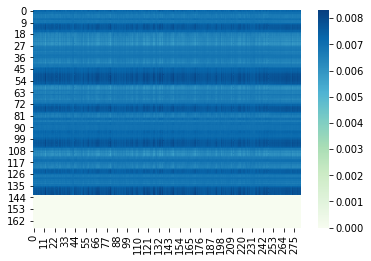

epoch:  1
training average loss: 2.0169570446014404, training time: 431.4881536960602
learning rate:  0.001  Teacher force:  0.1



epoch:  1
val average distance: 533.520162782094, training time: 21.717254877090454
learning rate:  0.001


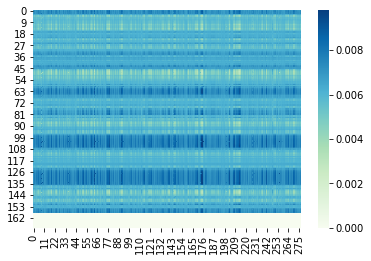

epoch:  2
training average loss: 1.7155922651290894, training time: 428.47878217697144
learning rate:  0.001  Teacher force:  0.1



epoch:  2
val average distance: 533.5301516833148, training time: 21.936543226242065
learning rate:  0.001


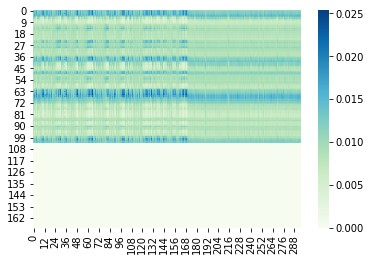

epoch:  3
training average loss: 1.6319326162338257, training time: 435.28528666496277
learning rate:  0.001  Teacher force:  0.1



epoch:  3
val average distance: 534.6655567887533, training time: 22.752808332443237
learning rate:  0.001


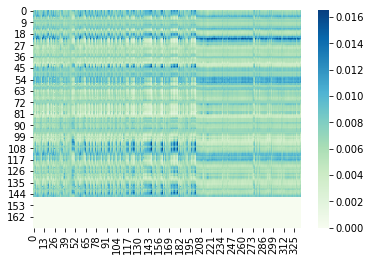

epoch:  4
training average loss: 1.5908981561660767, training time: 441.58890295028687
learning rate:  0.001  Teacher force:  0.1



epoch:  4
val average distance: 531.1890492045875, training time: 22.520612478256226
learning rate:  0.001


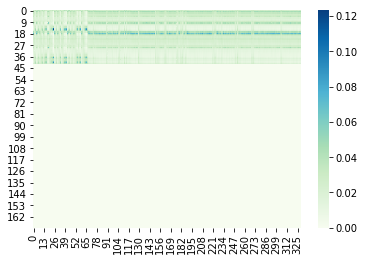

epoch:  5
training average loss: 1.5594477653503418, training time: 447.0280108451843
learning rate:  0.001  Teacher force:  0.1



epoch:  5
val average distance: 531.3544210136885, training time: 22.866371393203735
learning rate:  0.001


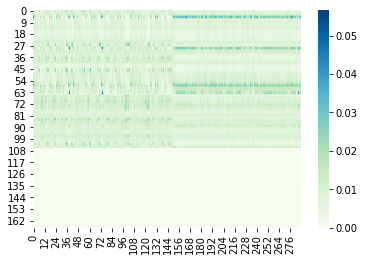

epoch:  6
training average loss: 1.5429069995880127, training time: 440.1448531150818
learning rate:  0.001  Teacher force:  0.1



epoch:  6
val average distance: 528.6773954864965, training time: 22.56550097465515
learning rate:  0.001


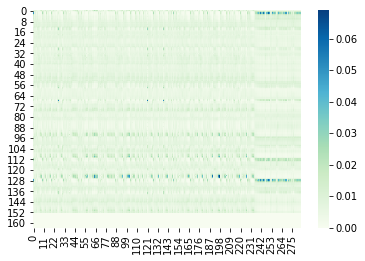

epoch:  7
training average loss: 1.523734211921692, training time: 430.6404459476471
learning rate:  0.001  Teacher force:  0.1



epoch:  7
val average distance: 533.6966333703292, training time: 21.813562154769897
learning rate:  0.001


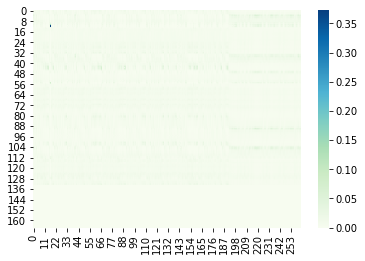

epoch:  8
training average loss: 1.5126985311508179, training time: 430.87909173965454
learning rate:  0.001  Teacher force:  0.1



epoch:  8
val average distance: 528.2415834258231, training time: 22.392225980758667
learning rate:  0.001


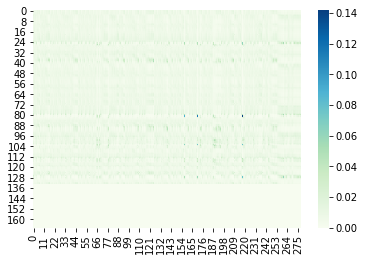

epoch:  9
training average loss: 1.5021125078201294, training time: 428.0801646709442
learning rate:  0.001  Teacher force:  0.1



epoch:  9
val average distance: 526.9182389937107, training time: 21.965235710144043
learning rate:  0.001


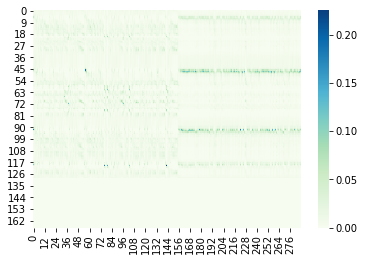

epoch:  10
training average loss: 1.491819977760315, training time: 424.9274799823761
learning rate:  0.001  Teacher force:  0.1



epoch:  10
val average distance: 528.0203477617462, training time: 21.776381731033325
learning rate:  0.001


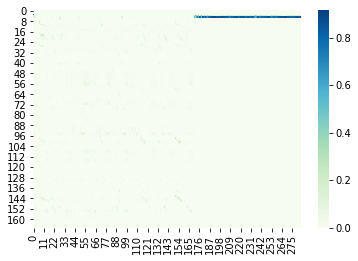

epoch:  11
training average loss: 1.4755589962005615, training time: 427.41042256355286
learning rate:  0.001  Teacher force:  0.1



epoch:  11
val average distance: 508.6759156492786, training time: 22.180562019348145
learning rate:  0.001


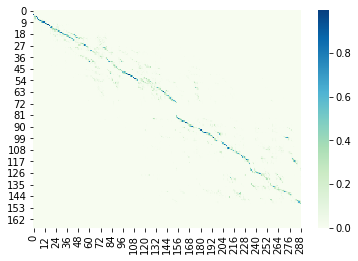

epoch:  12
training average loss: 1.3984742164611816, training time: 432.1517460346222
learning rate:  0.001  Teacher force:  0.1



epoch:  12
val average distance: 106.83425823159452, training time: 21.310422658920288
learning rate:  0.001


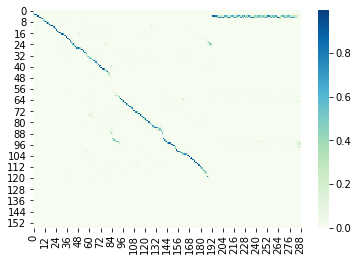

epoch:  13
training average loss: 0.8443040251731873, training time: 428.0045702457428
learning rate:  0.001  Teacher force:  0.1



epoch:  13
val average distance: 137.80540140584534, training time: 21.344572067260742
learning rate:  0.001


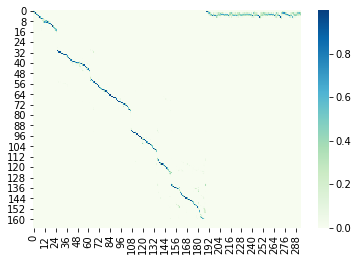

epoch:  14
training average loss: 0.7860978245735168, training time: 431.12912106513977
learning rate:  0.001  Teacher force:  0.1



epoch:  14
val average distance: 64.80651128375878, training time: 21.471031427383423
learning rate:  0.001


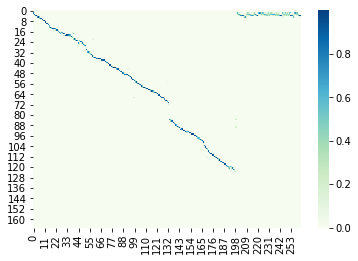

epoch:  15
training average loss: 0.566662609577179, training time: 430.61234164237976
learning rate:  0.001  Teacher force:  0.1



epoch:  15
val average distance: 50.302256751757305, training time: 21.581481456756592
learning rate:  0.001


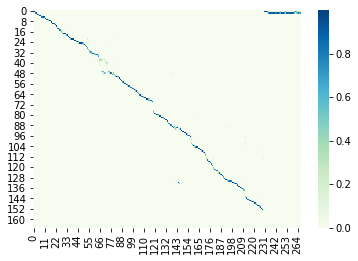

epoch:  16
training average loss: 0.5540116429328918, training time: 432.16704058647156
learning rate:  0.001  Teacher force:  0.1



epoch:  16
val average distance: 48.756566777654456, training time: 21.311397075653076
learning rate:  0.001


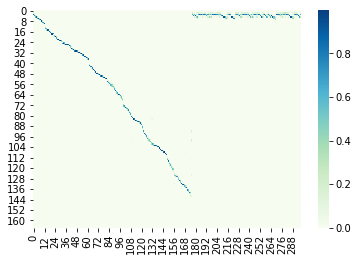

epoch:  17
training average loss: 0.4435615539550781, training time: 430.8490240573883
learning rate:  0.001  Teacher force:  0.1



epoch:  17
val average distance: 40.10173880873104, training time: 21.47871446609497
learning rate:  0.001


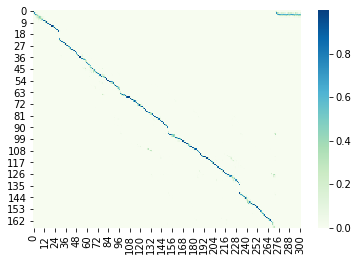

epoch:  18
training average loss: 0.38765567541122437, training time: 431.97275161743164
learning rate:  0.001  Teacher force:  0.1



epoch:  18
val average distance: 36.18793932667407, training time: 20.907139778137207
learning rate:  0.001


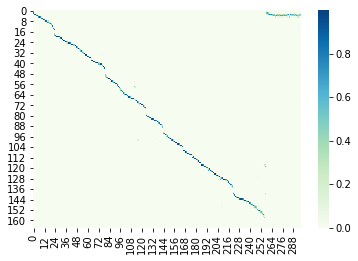

epoch:  19
training average loss: 0.3655490577220917, training time: 430.2616798877716
learning rate:  0.001  Teacher force:  0.1



epoch:  19
val average distance: 39.60488346281909, training time: 21.032103061676025
learning rate:  0.001


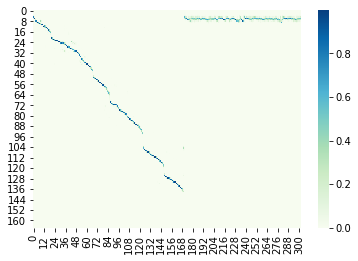

epoch:  20
training average loss: 0.33980095386505127, training time: 424.9955108165741
learning rate:  0.001  Teacher force:  0.1



epoch:  20
val average distance: 35.13429522752497, training time: 20.791480541229248
learning rate:  0.001


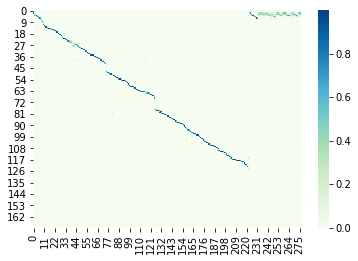

epoch:  21
training average loss: 0.3158036470413208, training time: 428.4529881477356
learning rate:  0.001  Teacher force:  0.1



epoch:  21
val average distance: 34.641139474657784, training time: 21.012507438659668
learning rate:  0.001


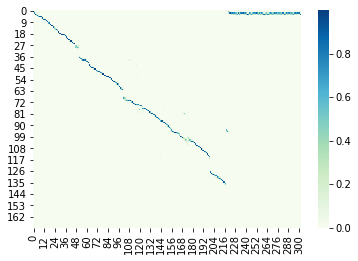

epoch:  22
training average loss: 0.33992722630500793, training time: 429.10739731788635
learning rate:  0.001  Teacher force:  0.1



epoch:  22
val average distance: 40.15982241953385, training time: 20.902956247329712
learning rate:  0.001


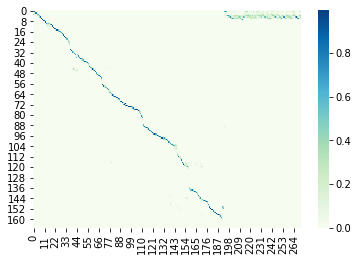

epoch:  23
training average loss: 0.30822688341140747, training time: 429.73827743530273
learning rate:  0.001  Teacher force:  0.1



epoch:  23
val average distance: 32.63041065482797, training time: 21.034643173217773
learning rate:  0.001


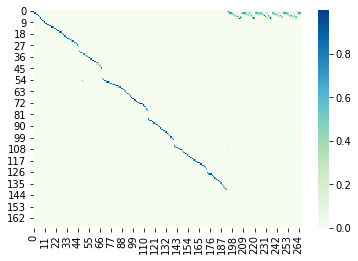

epoch:  24
training average loss: 0.2682640254497528, training time: 434.88657903671265
learning rate:  0.001  Teacher force:  0.1



epoch:  24
val average distance: 31.764335923048463, training time: 21.68449854850769
learning rate:  0.001


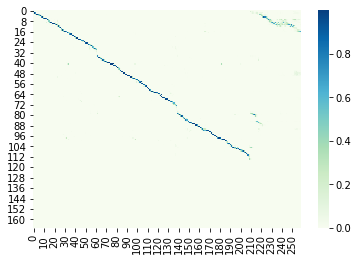

epoch:  25
training average loss: 0.28124046325683594, training time: 432.205623626709
learning rate:  0.001  Teacher force:  0.1



epoch:  25
val average distance: 67.43285238623751, training time: 21.32248544692993
learning rate:  0.001


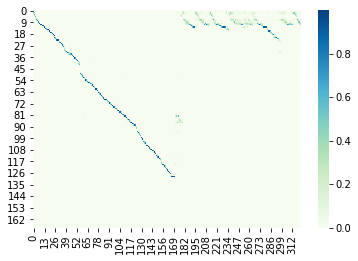

epoch:  26
training average loss: 0.2759392261505127, training time: 433.0569670200348
learning rate:  0.001  Teacher force:  0.1



epoch:  26
val average distance: 32.78542360340363, training time: 21.838048219680786
learning rate:  0.001


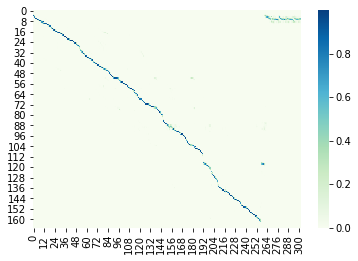

epoch:  27
training average loss: 0.2352834790945053, training time: 435.784517288208
learning rate:  0.001  Teacher force:  0.1



epoch:  27
val average distance: 31.035146133925267, training time: 21.50156807899475
learning rate:  0.001


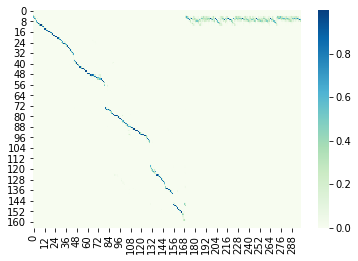

epoch:  28
training average loss: 0.23193494975566864, training time: 434.29550671577454
learning rate:  0.001  Teacher force:  0.1



epoch:  28
val average distance: 30.476137624861266, training time: 21.609089851379395
learning rate:  0.001


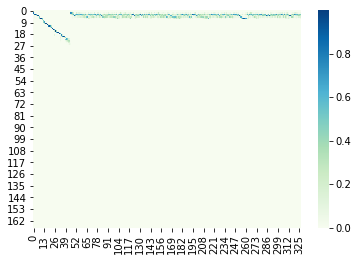

epoch:  29
training average loss: 0.2391444742679596, training time: 432.701847076416
learning rate:  0.001  Teacher force:  0.1



epoch:  29
val average distance: 31.290788013318537, training time: 21.3306667804718
learning rate:  0.001


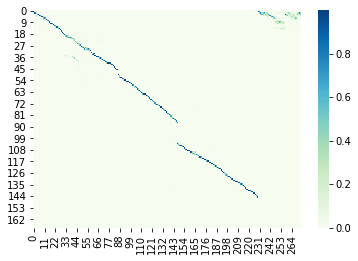

epoch:  30
training average loss: 0.34091320633888245, training time: 430.84877824783325
learning rate:  0.001  Teacher force:  0.1



epoch:  30
val average distance: 36.88827229004809, training time: 21.56202530860901
learning rate:  0.001


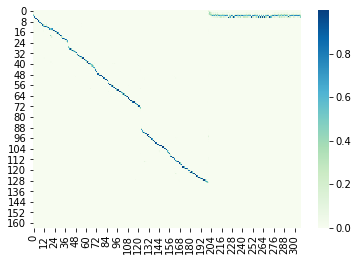

epoch:  31
training average loss: 0.27551156282424927, training time: 432.82220792770386
learning rate:  0.001  Teacher force:  0.1



epoch:  31
val average distance: 30.147983721790602, training time: 21.33472180366516
learning rate:  0.001


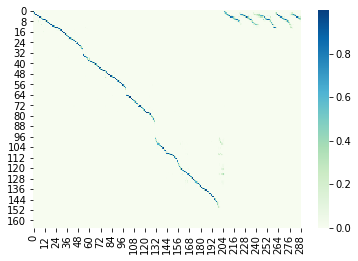

epoch:  32
training average loss: 0.23268276453018188, training time: 436.458279132843
learning rate:  0.001  Teacher force:  0.1



epoch:  32
val average distance: 26.935997040325564, training time: 21.908076286315918
learning rate:  0.001


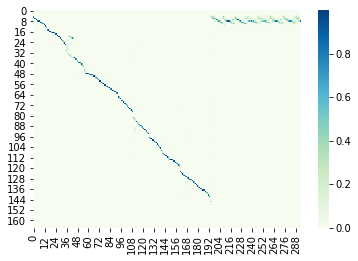

epoch:  33
training average loss: 0.21670982241630554, training time: 441.00246119499207
learning rate:  0.001  Teacher force:  0.1



epoch:  33
val average distance: 46.210876803551606, training time: 22.130692720413208
learning rate:  0.001


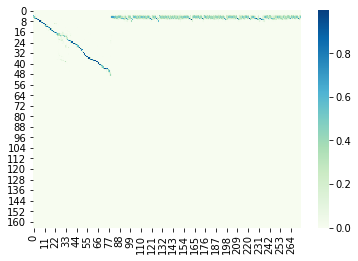

epoch:  34
training average loss: 0.23591430485248566, training time: 441.22437834739685
learning rate:  0.001  Teacher force:  0.1



epoch:  34
val average distance: 30.85904550499445, training time: 21.88347053527832
learning rate:  0.001


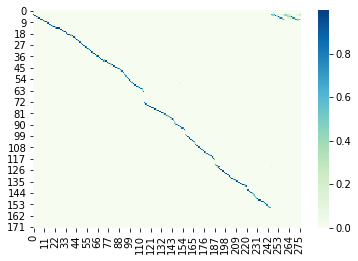

epoch:  35
training average loss: 0.23026683926582336, training time: 441.0621979236603
learning rate:  0.001  Teacher force:  0.1



epoch:  35
val average distance: 29.238623751387347, training time: 22.470667123794556
learning rate:  0.001


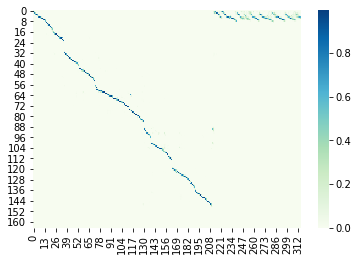

epoch:  36
training average loss: 0.1987931728363037, training time: 441.51154613494873
learning rate:  0.001  Teacher force:  0.1



epoch:  36
val average distance: 27.78505364409915, training time: 21.916094064712524
learning rate:  0.001


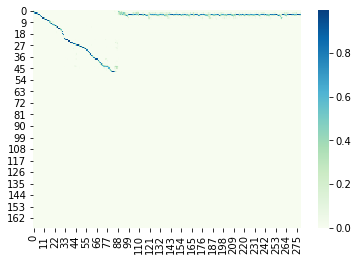

epoch:  37
training average loss: 0.17912907898426056, training time: 436.2447865009308
learning rate:  0.001  Teacher force:  0.1



epoch:  37
val average distance: 27.45763965963744, training time: 21.7548086643219
learning rate:  0.001


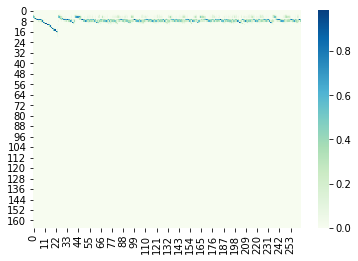

epoch:  38
training average loss: 0.17584781348705292, training time: 444.3561325073242
learning rate:  0.001  Teacher force:  0.1



epoch:  38
val average distance: 28.433592304846467, training time: 22.35820698738098
learning rate:  0.001


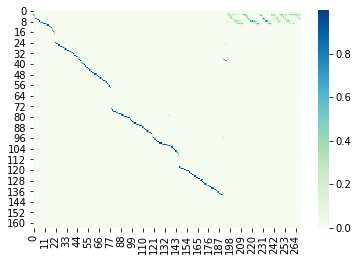

epoch:  39
training average loss: 0.18586523830890656, training time: 443.7822949886322
learning rate:  0.001  Teacher force:  0.1



epoch:  39
val average distance: 30.37587865334813, training time: 21.73161005973816
learning rate:  0.001


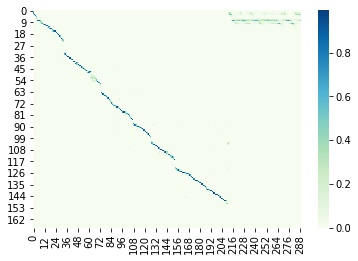

epoch:  40
training average loss: 0.17476217448711395, training time: 437.2662818431854
learning rate:  0.001  Teacher force:  0.1



epoch:  40
val average distance: 27.62301146873844, training time: 21.294488430023193
learning rate:  0.001


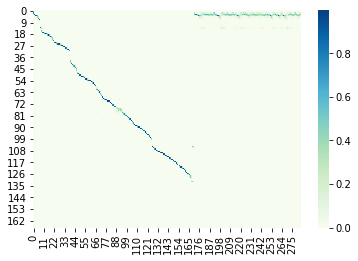

epoch:  41
training average loss: 0.17319296300411224, training time: 435.92612504959106
learning rate:  0.001  Teacher force:  0.1



epoch:  41
val average distance: 27.709951905290417, training time: 21.446841955184937
learning rate:  0.001


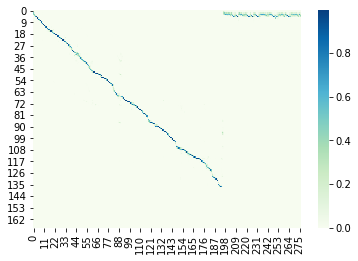

epoch:  42
training average loss: 0.2375440150499344, training time: 437.60010862350464
learning rate:  0.001  Teacher force:  0.1



epoch:  42
val average distance: 28.00110987791343, training time: 21.673796892166138
learning rate:  0.001


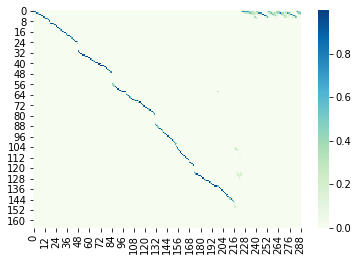

epoch:  43
training average loss: 0.19279751181602478, training time: 439.5806987285614
learning rate:  0.001  Teacher force:  0.1



epoch:  43
val average distance: 29.164261931187568, training time: 21.81182885169983
learning rate:  0.001


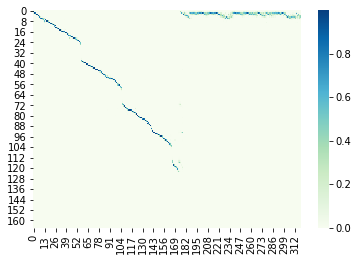

epoch:  44
training average loss: 0.17566153407096863, training time: 430.8425672054291
learning rate:  0.001  Teacher force:  0.1



epoch:  44
val average distance: 27.341472438031815, training time: 20.941057682037354
learning rate:  0.001


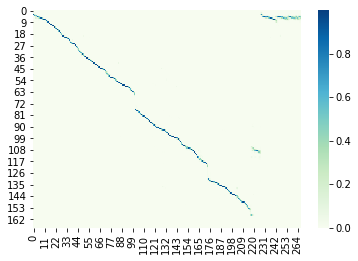

epoch:  45
training average loss: 0.17477670311927795, training time: 426.8029999732971
learning rate:  0.001  Teacher force:  0.1



epoch:  45
val average distance: 31.42175360710322, training time: 20.769853830337524
learning rate:  0.001


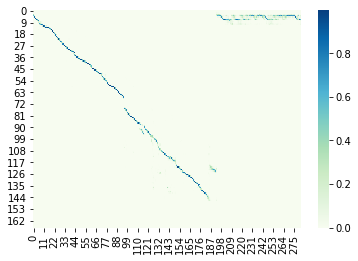

epoch:  46
training average loss: 0.215138241648674, training time: 427.47268772125244
learning rate:  0.001  Teacher force:  0.1



epoch:  46
val average distance: 27.743988161302255, training time: 21.03878617286682
learning rate:  0.001


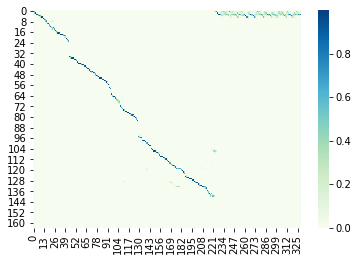

epoch:  47
training average loss: 0.22378548979759216, training time: 429.01388335227966
learning rate:  0.001  Teacher force:  0.1



epoch:  47
val average distance: 27.290048094709583, training time: 20.824909925460815
learning rate:  0.001


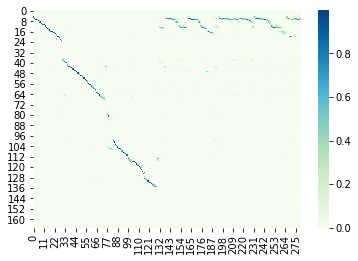

epoch:  48
training average loss: 0.26598358154296875, training time: 431.15446424484253
learning rate:  0.001  Teacher force:  0.1



epoch:  48
val average distance: 65.77025527192009, training time: 21.84163475036621
learning rate:  0.001


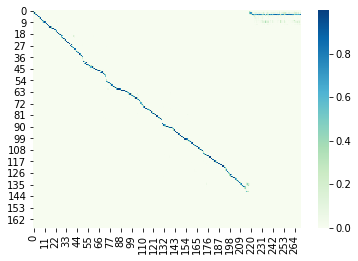

epoch:  49
training average loss: 0.3162592649459839, training time: 431.0247526168823
learning rate:  0.001  Teacher force:  0.1



epoch:  49
val average distance: 28.73399926008139, training time: 21.42134952545166
learning rate:  0.001


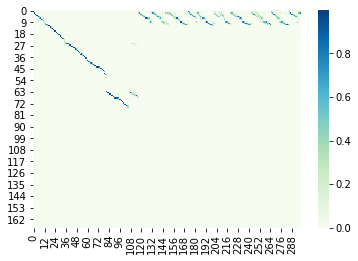

epoch:  50
training average loss: 0.19883453845977783, training time: 443.2132046222687
learning rate:  0.001  Teacher force:  0.1



epoch:  50
val average distance: 26.676285608583054, training time: 22.08246946334839
learning rate:  0.001


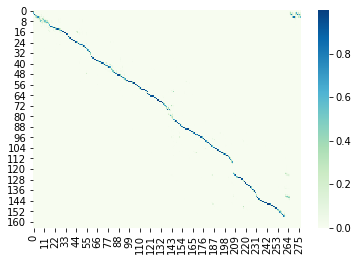

epoch:  51
training average loss: 0.16257449984550476, training time: 443.20287442207336
learning rate:  0.001  Teacher force:  0.1



epoch:  51
val average distance: 26.381058083610803, training time: 21.84900140762329
learning rate:  0.001


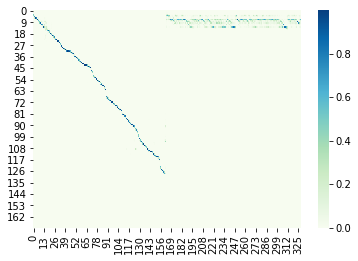

epoch:  52
training average loss: 0.14850521087646484, training time: 444.31669330596924
learning rate:  0.001  Teacher force:  0.1



epoch:  52
val average distance: 26.580836108028116, training time: 21.99642848968506
learning rate:  0.001


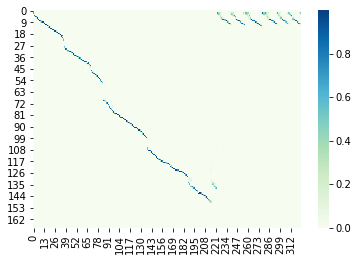

epoch:  53
training average loss: 0.14256222546100616, training time: 443.2886538505554
learning rate:  0.001  Teacher force:  0.1



epoch:  53
val average distance: 26.38216796152423, training time: 22.31635880470276
learning rate:  0.001


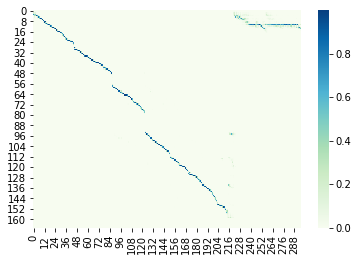

epoch:  54
training average loss: 0.14248625934123993, training time: 443.89254236221313
learning rate:  0.001  Teacher force:  0.1



epoch:  54
val average distance: 26.384017758046614, training time: 22.35959792137146
learning rate:  0.001


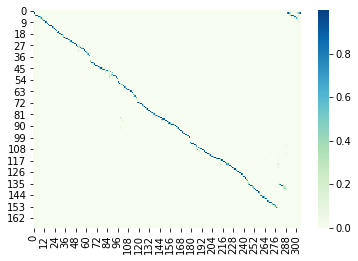

epoch:  55
training average loss: 0.13867005705833435, training time: 444.4160051345825
learning rate:  0.001  Teacher force:  0.1



epoch:  55
val average distance: 25.929707732149463, training time: 22.098770141601562
learning rate:  0.001


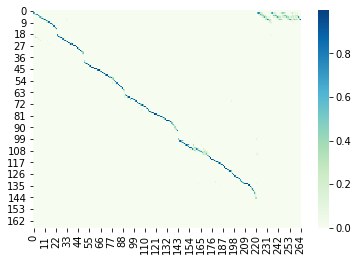

epoch:  56
training average loss: 0.18202531337738037, training time: 439.51970291137695
learning rate:  0.001  Teacher force:  0.1



epoch:  56
val average distance: 31.748427672955973, training time: 21.58538246154785
learning rate:  0.001


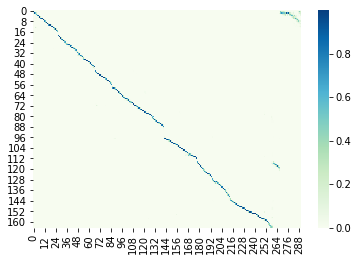

epoch:  57
training average loss: 0.14911377429962158, training time: 435.78910875320435
learning rate:  0.001  Teacher force:  0.1



epoch:  57
val average distance: 25.79023307436182, training time: 21.650587797164917
learning rate:  0.001


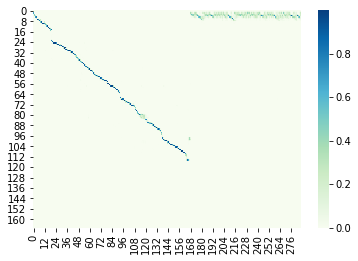

epoch:  58
training average loss: 0.16646502912044525, training time: 434.5143711566925
learning rate:  0.001  Teacher force:  0.1



epoch:  58
val average distance: 36.82315945246023, training time: 21.777339220046997
learning rate:  0.001


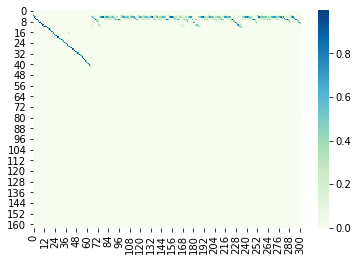

epoch:  59
training average loss: 0.20288842916488647, training time: 433.67042803764343
learning rate:  0.001  Teacher force:  0.1



epoch:  59
val average distance: 26.372179060303367, training time: 21.54366636276245
learning rate:  0.001


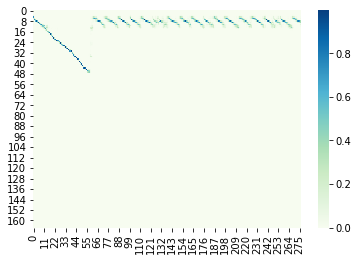

epoch:  60
training average loss: 0.1416325867176056, training time: 436.1322662830353
learning rate:  0.001  Teacher force:  0.1



epoch:  60
val average distance: 24.916019237883834, training time: 21.631032705307007
learning rate:  0.001


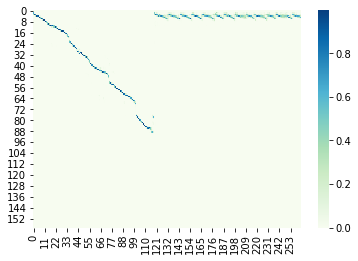

epoch:  61
training average loss: 0.14060664176940918, training time: 438.15373635292053
learning rate:  0.001  Teacher force:  0.1



epoch:  61
val average distance: 26.51609322974473, training time: 21.66597890853882
learning rate:  0.001


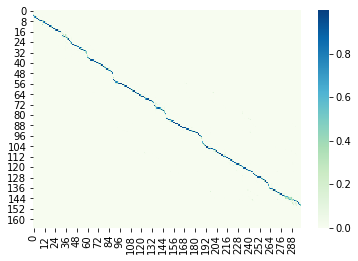

epoch:  62
training average loss: 0.14523817598819733, training time: 438.72766494750977
learning rate:  0.001  Teacher force:  0.1



epoch:  62
val average distance: 25.627820939696633, training time: 21.726663827896118
learning rate:  0.001


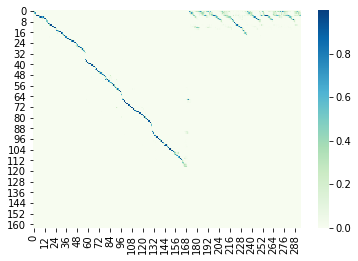

epoch:  63
training average loss: 0.14544296264648438, training time: 435.82561564445496
learning rate:  0.001  Teacher force:  0.1



epoch:  63
val average distance: 25.81243063263041, training time: 21.484023094177246
learning rate:  0.001


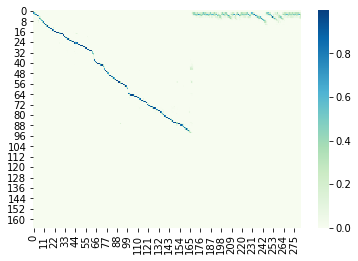

epoch:  64
training average loss: 0.14636678993701935, training time: 438.5365936756134
learning rate:  0.001  Teacher force:  0.1



epoch:  64
val average distance: 27.635220125786162, training time: 21.716774702072144
learning rate:  0.001


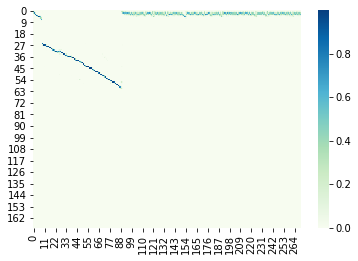

epoch:  65
training average loss: 0.1750425398349762, training time: 435.7950189113617
learning rate:  0.001  Teacher force:  0.1



epoch:  65
val average distance: 27.111727709951904, training time: 21.17115569114685
learning rate:  0.001


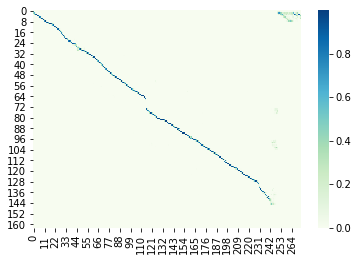

epoch:  66
training average loss: 0.14424960315227509, training time: 434.49384665489197
learning rate:  0.001  Teacher force:  0.1



epoch:  66
val average distance: 24.835738068812432, training time: 21.306703090667725
learning rate:  0.001


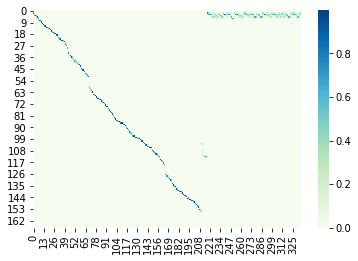

epoch:  67
training average loss: 0.13350658118724823, training time: 431.42683458328247
learning rate:  0.001  Teacher force:  0.1



epoch:  67
val average distance: 24.867184609692934, training time: 21.109466791152954
learning rate:  0.001


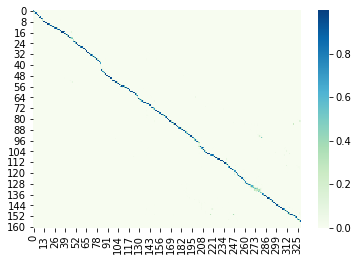

epoch:  68
training average loss: 0.15501879155635834, training time: 432.8273358345032
learning rate:  0.001  Teacher force:  0.1



epoch:  68
val average distance: 26.28930817610063, training time: 21.3505859375
learning rate:  0.001


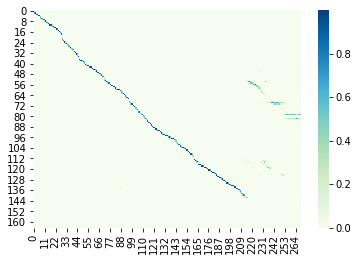

epoch:  69
training average loss: 0.32087811827659607, training time: 433.7136960029602
learning rate:  0.001  Teacher force:  0.1



epoch:  69
val average distance: 28.25009248982612, training time: 21.57665514945984
learning rate:  0.001


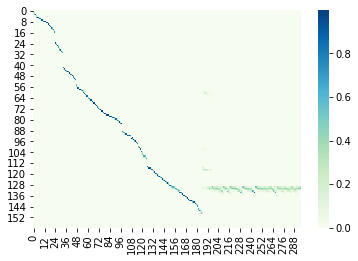

epoch:  70
training average loss: 0.17684975266456604, training time: 432.6584458351135
learning rate:  0.001  Teacher force:  0.1



epoch:  70
val average distance: 26.05401405845357, training time: 21.3980712890625
learning rate:  0.001


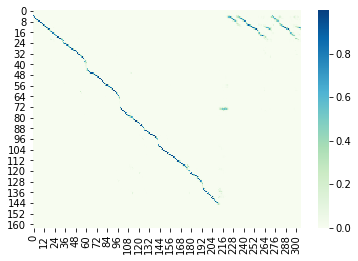

epoch:  71
training average loss: 0.1709812879562378, training time: 435.56339263916016
learning rate:  0.001  Teacher force:  0.1



epoch:  71
val average distance: 24.35405105438402, training time: 21.855219841003418
learning rate:  0.001


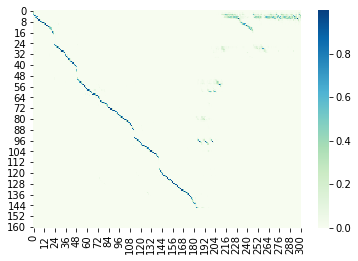

epoch:  72
training average loss: 0.19598086178302765, training time: 435.1624228954315
learning rate:  0.001  Teacher force:  0.1



epoch:  72
val average distance: 26.930447650758417, training time: 21.665190935134888
learning rate:  0.001


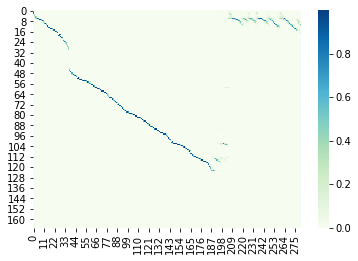

epoch:  73
training average loss: 0.15999414026737213, training time: 434.78778171539307
learning rate:  0.001  Teacher force:  0.1



epoch:  73
val average distance: 25.569367369589344, training time: 21.643528938293457
learning rate:  0.001


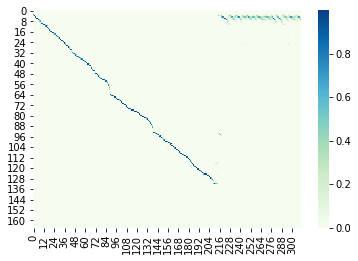

epoch:  74
training average loss: 0.24005092680454254, training time: 437.8232309818268
learning rate:  0.001  Teacher force:  0.1



epoch:  74
val average distance: 25.002219755826857, training time: 21.923383712768555
learning rate:  0.001


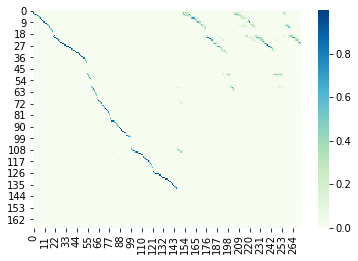

epoch:  75
training average loss: 0.16483309864997864, training time: 442.50193643569946
learning rate:  0.001  Teacher force:  0.1



epoch:  75
val average distance: 25.735109137994822, training time: 21.77458095550537
learning rate:  0.001


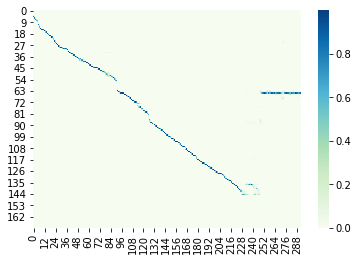

epoch:  76
training average loss: 0.14566229283809662, training time: 444.3294241428375
learning rate:  0.001  Teacher force:  0.1



epoch:  76
val average distance: 24.065482796892343, training time: 21.582759141921997
learning rate:  0.001


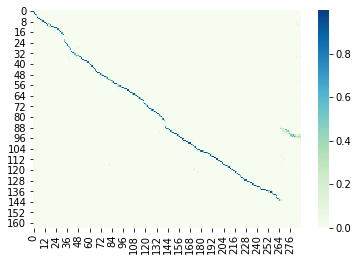

epoch:  77
training average loss: 0.13115361332893372, training time: 437.56738090515137
learning rate:  0.001  Teacher force:  0.1



epoch:  77
val average distance: 26.203847576766556, training time: 21.08163285255432
learning rate:  0.001


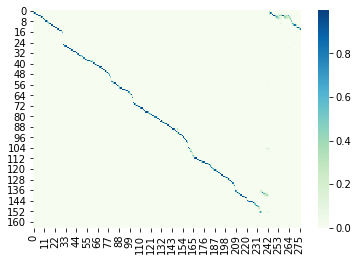

epoch:  78
training average loss: 0.13274312019348145, training time: 426.81186723709106
learning rate:  0.001  Teacher force:  0.1



epoch:  78
val average distance: 25.527931927487977, training time: 20.84562587738037
learning rate:  0.001


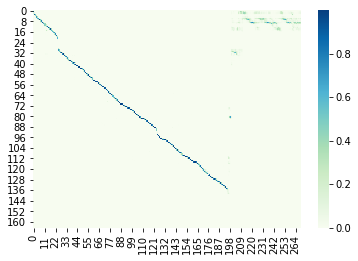

epoch:  79
training average loss: 0.18357199430465698, training time: 427.1841185092926
learning rate:  0.001  Teacher force:  0.1



epoch:  79
val average distance: 23.600073991860896, training time: 21.153189659118652
learning rate:  0.001


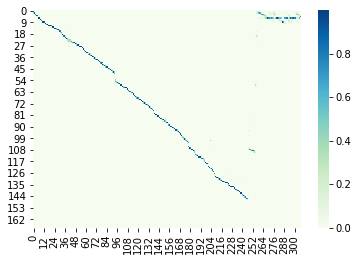

epoch:  80
training average loss: 0.13412520289421082, training time: 430.46955394744873
learning rate:  0.001  Teacher force:  0.1



epoch:  80
val average distance: 24.037735849056602, training time: 21.295095920562744
learning rate:  0.001


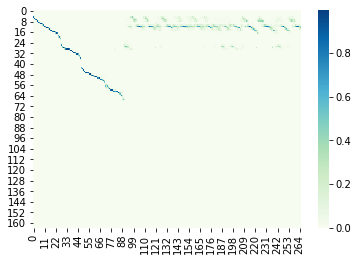

epoch:  81
training average loss: 0.17329208552837372, training time: 434.071572303772
learning rate:  0.001  Teacher force:  0.1



epoch:  81
val average distance: 24.77543470218276, training time: 21.57559895515442
learning rate:  0.001


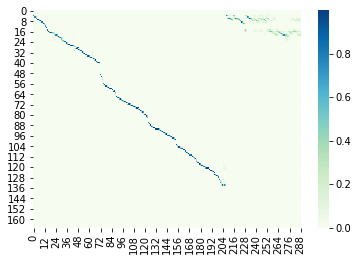

epoch:  82
training average loss: 0.13879182934761047, training time: 437.4935612678528
learning rate:  0.001  Teacher force:  0.1



epoch:  82
val average distance: 24.766185719570846, training time: 21.80572485923767
learning rate:  0.001


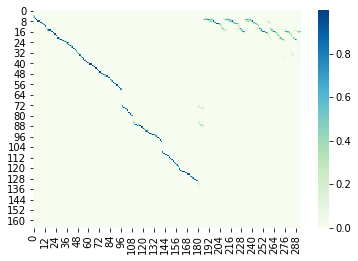

epoch:  83
training average loss: 0.12678126990795135, training time: 435.70361971855164
learning rate:  0.001  Teacher force:  0.1



epoch:  83
val average distance: 24.094709581945985, training time: 21.43482255935669
learning rate:  0.001


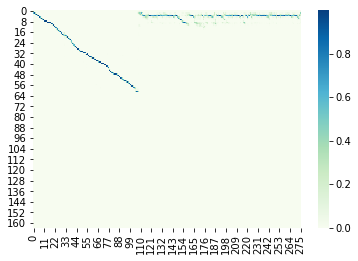

epoch:  84
training average loss: 0.1208900436758995, training time: 436.05105447769165
learning rate:  0.001  Teacher force:  0.1



epoch:  84
val average distance: 24.503884572697004, training time: 21.448857307434082
learning rate:  0.001


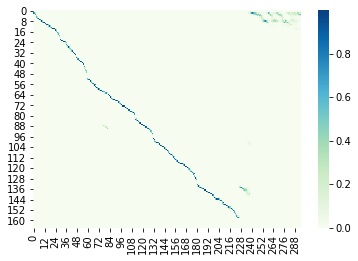

epoch:  85
training average loss: 0.13999783992767334, training time: 436.1290862560272
learning rate:  0.001  Teacher force:  0.1



epoch:  85
val average distance: 25.111727709951904, training time: 21.779579162597656
learning rate:  0.001


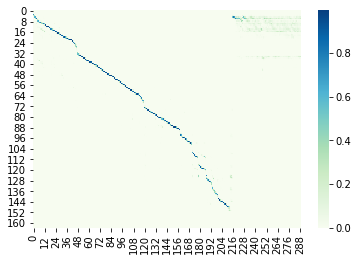

epoch:  86
training average loss: 0.15269315242767334, training time: 437.713583946228
learning rate:  0.001  Teacher force:  0.1



epoch:  86
val average distance: 37.65408805031446, training time: 22.04192543029785
learning rate:  0.001


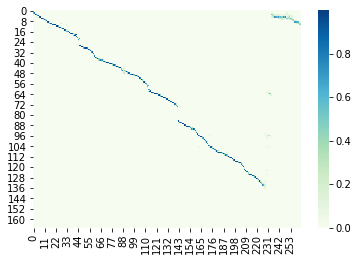

epoch:  87
training average loss: 0.1592627316713333, training time: 442.18606901168823
learning rate:  0.001  Teacher force:  0.1



epoch:  87
val average distance: 23.647058823529413, training time: 22.008903980255127
learning rate:  0.001


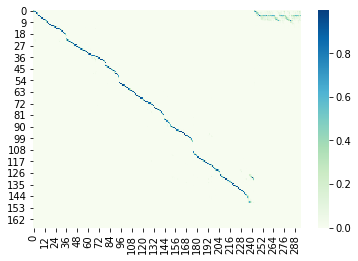

epoch:  88
training average loss: 0.11972562223672867, training time: 439.45115399360657
learning rate:  0.001  Teacher force:  0.1



epoch:  88
val average distance: 24.27192008879023, training time: 21.756728887557983
learning rate:  0.001


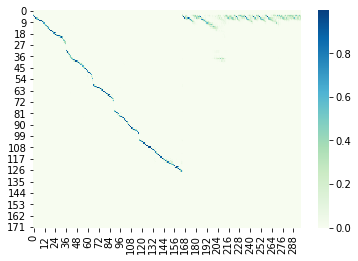

epoch:  89
training average loss: 0.12952131032943726, training time: 441.74573159217834
learning rate:  0.001  Teacher force:  0.1



epoch:  89
val average distance: 24.547169811320753, training time: 21.87594485282898
learning rate:  0.001


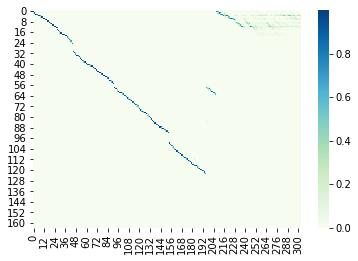

epoch:  90
training average loss: 0.17452052235603333, training time: 439.024879693985
learning rate:  0.001  Teacher force:  0.1



epoch:  90
val average distance: 23.91527931927488, training time: 21.724276304244995
learning rate:  0.001


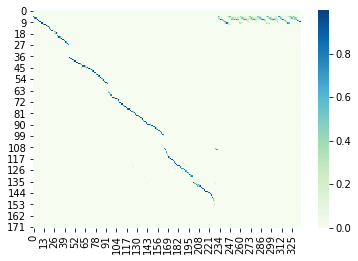

epoch:  91
training average loss: 0.19782976806163788, training time: 440.723507642746
learning rate:  0.001  Teacher force:  0.1



epoch:  91
val average distance: 30.91934887162412, training time: 21.681018114089966
learning rate:  0.001


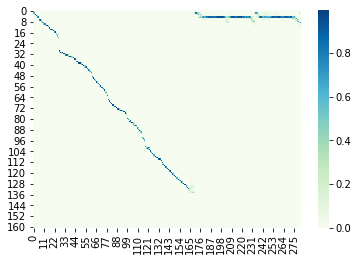

epoch:  92
training average loss: 0.17071132361888885, training time: 438.4883818626404
learning rate:  0.001  Teacher force:  0.1



epoch:  92
val average distance: 24.62079171291158, training time: 21.701843976974487
learning rate:  0.001


In [ ]:
t_f = 0.1
for epoch in range(1,n_epochs):

    # if (epoch % 5 == 0) and (t_f < 1):
    #     t_f += 0.1

    start_time = time.time()
    avg_loss = train(model, train_loader, criterion, optimizer, mode)
    end_time = time.time()

    #print useful info
    print("epoch: ",epoch)
    print("training average loss: {:}, training time: {:}".format(avg_loss,(end_time - start_time)))
    print('learning rate: ',get_lr(optimizer)," Teacher force: ",t_f)
    # val(model, valid_loader)

    start_time = time.time()
    avg_distance = val(model, valid_loader)
    end_time = time.time()

    #print useful info
    print("epoch: ",epoch)
    print("val average distance: {:}, training time: {:}".format(avg_distance,(end_time - start_time)))
    print('learning rate: ',get_lr(optimizer))


    if avg_distance < distance:
        distance = avg_distance
        torch.save(
            {
                'model_state_dict':model.state_dict(),
                'optimizer_state_dict':optimizer.state_dict()
            },
            '/content/gdrive/My Drive/11785-hw/hw4/model3/moreLayer_{:}.pickle'.format(epoch)

        )
    #use sheduler
    # scheduler.step(avg_distance)

In [ ]:
checkpoint = torch.load('/content/gdrive/My Drive/11785-hw/hw4/model3/tfAdd2_35.pickle') #four_4 #more_layer_79 23.6 ||35 -- 21
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
def idx2string(index_list,stop_index):
    string_list = []

    for curr_time in index_list:

        curr_string = ""
        for idx in curr_time:
            if idx == stop_index:
                break
            else:
                curr_string += index2letter[idx]

        string_list.append(curr_string)

    return string_list

In [ ]:
for g in optimizer.param_groups:
    g['lr'] = 0.008

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
#reference: # https://github.com/salesforce/awd-lstm-lm/blob/dfd3cb0235d2caf2847a4d53e1cbd495b781b5d2/locked_dropout.py#L5
class LockedDropout(nn.Module):
    def __init__(self, dropout = 0.3):
        super().__init__()
        self.dropout = dropout

    def forward(self, x):
        if not self.training or not self.dropout:
            return x
        m = x.data.new(1, x.size(1), x.size(2)).bernoulli_(1 - self.dropout)
        mask = Variable(m, requires_grad=False) / (1 - self.dropout)
        mask = mask.expand_as(x)
        return mask * x

In [ ]:
distance =1000 #tfadd 10 --- 24.1

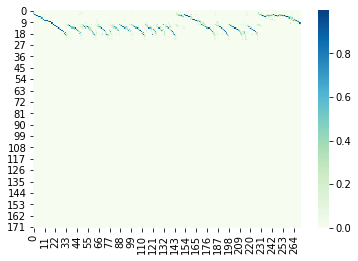

epoch:  0
training average loss: 0.40939128398895264, training time: 692.2955365180969
learning rate:  0.001  Teacher force:  0.4



epoch:  0
val average distance: 24.839437661857197, training time: 35.88846969604492
learning rate:  0.001


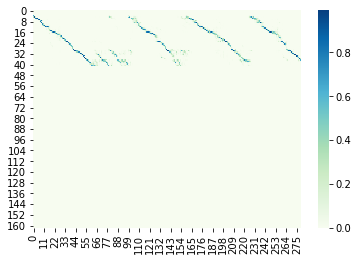

epoch:  1
training average loss: 0.3809799551963806, training time: 700.6200227737427
learning rate:  0.001  Teacher force:  0.4



epoch:  1
val average distance: 21.574546799852016, training time: 36.46022963523865
learning rate:  0.001


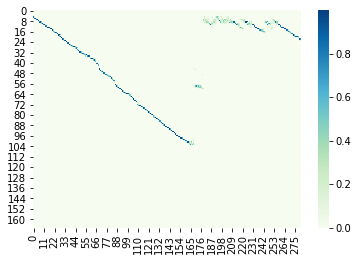

epoch:  2
training average loss: 0.37381723523139954, training time: 704.1856157779694
learning rate:  0.001  Teacher force:  0.4



epoch:  2
val average distance: 21.161302256751757, training time: 36.73088765144348
learning rate:  0.001


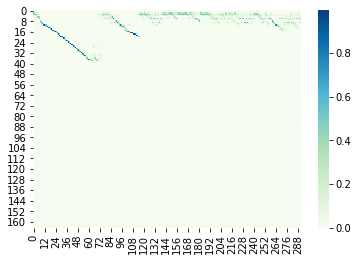

epoch:  3
training average loss: 0.4968743324279785, training time: 709.1787948608398
learning rate:  0.001  Teacher force:  0.4



epoch:  3
val average distance: 22.88013318534961, training time: 36.9242045879364
learning rate:  0.001


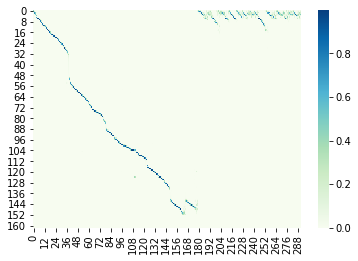

epoch:  4
training average loss: 0.48876771330833435, training time: 710.9035358428955
learning rate:  0.001  Teacher force:  0.4



epoch:  4
val average distance: 24.329263780984093, training time: 36.88790035247803
learning rate:  0.001


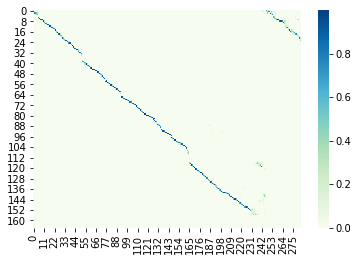

epoch:  5
training average loss: 0.5345694422721863, training time: 711.0042760372162
learning rate:  0.001  Teacher force:  0.4



epoch:  5
val average distance: 23.93007769145394, training time: 36.60741829872131
learning rate:  0.001


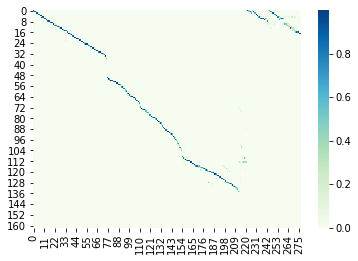

epoch:  6
training average loss: 0.4281149208545685, training time: 706.5289001464844
learning rate:  0.001  Teacher force:  0.4



epoch:  6
val average distance: 23.005919348871625, training time: 36.30174970626831
learning rate:  0.001


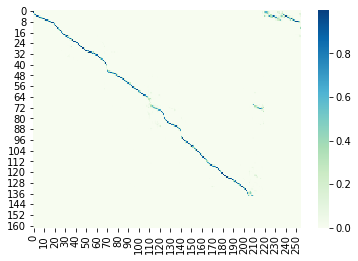

epoch:  7
training average loss: 0.4085797369480133, training time: 708.472975730896
learning rate:  0.001  Teacher force:  0.4



epoch:  7
val average distance: 22.90270070292268, training time: 36.87020659446716
learning rate:  0.001
Epoch     8: reducing learning rate of group 0 to 8.0000e-04.


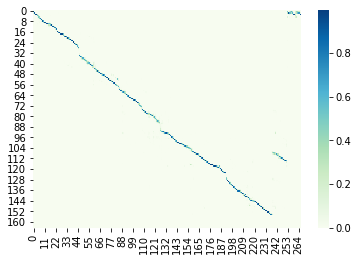

epoch:  8
training average loss: 0.3639708161354065, training time: 711.4416766166687
learning rate:  0.0008  Teacher force:  0.4



epoch:  8
val average distance: 22.592304846466888, training time: 36.868860721588135
learning rate:  0.0008


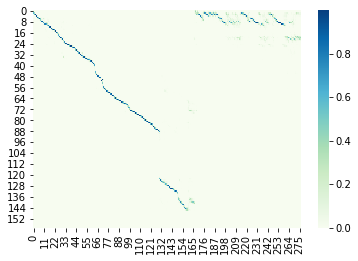

epoch:  9
training average loss: 0.35676103830337524, training time: 714.3358476161957
learning rate:  0.0008  Teacher force:  0.4



epoch:  9
val average distance: 22.02034776174621, training time: 37.2569465637207
learning rate:  0.0008


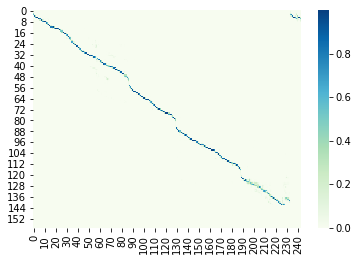

epoch:  10
training average loss: 0.35607847571372986, training time: 713.4501261711121
learning rate:  0.0008  Teacher force:  0.4



epoch:  10
val average distance: 21.75323714391417, training time: 36.71514534950256
learning rate:  0.0008


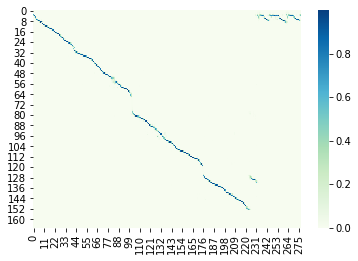

epoch:  11
training average loss: 0.30460309982299805, training time: 712.9044272899628
learning rate:  0.0008  Teacher force:  0.4



epoch:  11
val average distance: 20.50018497965224, training time: 37.647408962249756
learning rate:  0.0008


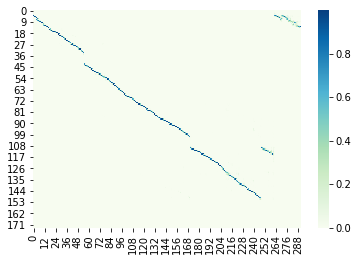

epoch:  12
training average loss: 0.3080328404903412, training time: 717.3409488201141
learning rate:  0.0008  Teacher force:  0.4



epoch:  12
val average distance: 20.27192008879023, training time: 37.505455017089844
learning rate:  0.0008


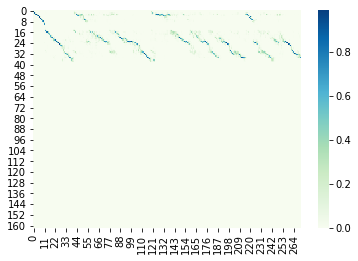

epoch:  13
training average loss: 0.30386120080947876, training time: 715.0058097839355
learning rate:  0.0008  Teacher force:  0.4



epoch:  13
val average distance: 25.98927118017018, training time: 37.20054650306702
learning rate:  0.0008


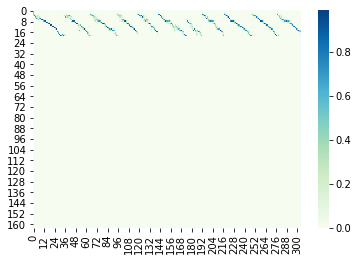

epoch:  14
training average loss: 0.3396516442298889, training time: 712.7909231185913
learning rate:  0.0008  Teacher force:  0.4



epoch:  14
val average distance: 20.576026637069923, training time: 36.68791460990906
learning rate:  0.0008


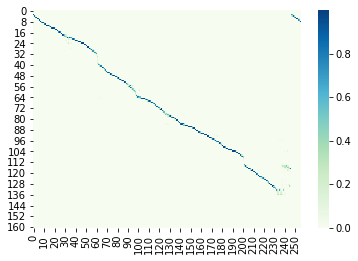

epoch:  15
training average loss: 0.3008613586425781, training time: 703.4967484474182
learning rate:  0.0008  Teacher force:  0.4



epoch:  15
val average distance: 21.105068442471328, training time: 35.934232234954834
learning rate:  0.0008


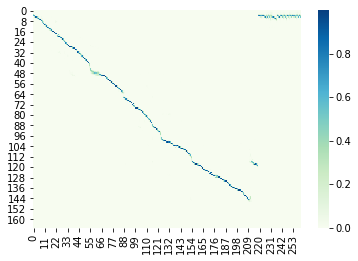

epoch:  16
training average loss: 0.30502593517303467, training time: 695.1382839679718
learning rate:  0.0008  Teacher force:  0.4



epoch:  16
val average distance: 21.542730299667035, training time: 35.812976598739624
learning rate:  0.0008


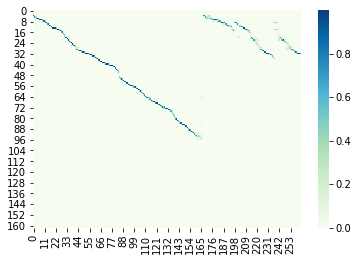

epoch:  17
training average loss: 0.30524876713752747, training time: 693.5785493850708
learning rate:  0.0008  Teacher force:  0.4



epoch:  17
val average distance: 20.67813540510544, training time: 36.08823251724243
learning rate:  0.0008
Epoch    18: reducing learning rate of group 0 to 6.4000e-04.


In [ ]:
t_f = 0.4
for epoch in range(0,n_epochs):

    # if (epoch % 5 == 0) and (t_f < 0.4):
    #     t_f += 0.05

    start_time = time.time()
    avg_loss = train(model, train_loader, criterion, optimizer, mode,teacher_f = t_f)
    end_time = time.time()

    #print useful info
    print("epoch: ",epoch)
    print("training average loss: {:}, training time: {:}".format(avg_loss,(end_time - start_time)))
    print('learning rate: ',get_lr(optimizer)," Teacher force: ",t_f)
    # val(model, valid_loader)

    start_time = time.time()
    avg_distance = val(model, valid_loader)
    end_time = time.time()

    #print useful info
    print("epoch: ",epoch)
    print("val average distance: {:}, training time: {:}".format(avg_distance,(end_time - start_time)))
    print('learning rate: ',get_lr(optimizer))


    if avg_distance < distance:
        distance = avg_distance
        torch.save(
            {
                'model_state_dict':model.state_dict(),
                'optimizer_state_dict':optimizer.state_dict()
            },
            '/content/gdrive/My Drive/11785-hw/hw4/model3/tfAdd3_{:}.pickle'.format(epoch)

        )
    #use sheduler
    scheduler.step(avg_distance)